In [9]:
import os
import xarray as xr
import numpy as np
import cftime
import matplotlib.pyplot as plt


from osprey.means.eof import preproc_pattern_3D, preproc_timeseries_3D, preproc_var_3D, postproc_var_3D, preproc_forecast_3D
from osprey.actions.reader import reader_rebuilt, reader_nemo, preproc_nemo
from osprey.utils.folders import folders
from osprey.means.eof import save_EOF, detrend_3D
from osprey.means.means import globalmean, spacemean, timemean
from osprey.utils.time import get_startleg, get_year, get_forecast_year
from osprey.utils.utils import remove_existing_filelist, run_bash_command
from osprey.utils import run_cdo

In [13]:
expname = "FE00"
var = "thetao"
ndim ="3D"
endleg = 11
yearspan = 5
yearleap = 10

In [14]:
startleg = get_startleg(endleg, yearspan)
startyear = get_year(startleg)
endyear = get_year(endleg)
window = endyear - startyear + 1

In [15]:
dirs = folders(expname)

In [16]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")    
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries_3D)
    #p = timeseries.polyfit(dim='time', deg=1, skipna = True)
    # theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    theta = timeseries[var].isel(time=-1)
    basis = pattern.isel(time=i)
    field = field + theta*basis
field = field.drop_vars({'time'})

In [17]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
ave = timemean(xdata, var, )

In [18]:
total = field + ave

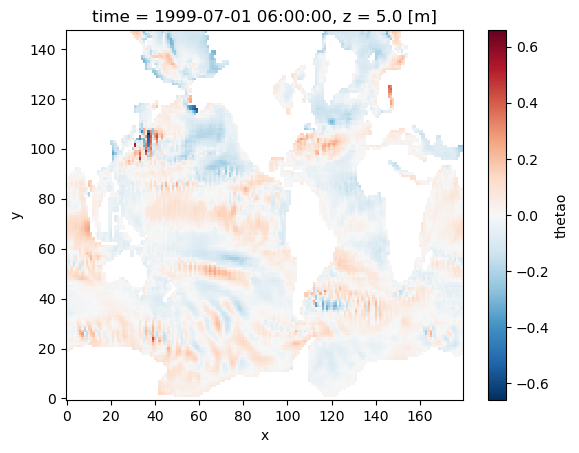

In [19]:
delta = xdata[var].isel(time=-1,z=0)-total[var].isel(z=0)
delta.plot()

In [16]:
save_EOF(expname, startyear, endyear, field, var)

File /ec/res4/scratch/itas/martini/FE00/011/thetao_product.nc not found.


In [17]:
run_cdo.retrend(expname, var, endleg)

File /ec/res4/scratch/itas/martini/lfr0/050/thetao_forecast.nc not found.
Command: 'cdo add /ec/res4/scratch/itas/martini/lfr0/050/thetao_product.nc -timmean /ec/res4/scratch/itas/martini/lfr0/050/thetao.nc /ec/res4/scratch/itas/martini/lfr0/050/thetao_forecast.nc' 

cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - time_counter_bnds
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - deptht_bnds
cdi  warning (cdfInqContents): Coordinates variable time_counter can't be assigned!
cdi  warning (cdfInqContents): Coordinates variable zaxis_Reduced can't be assigned!



In [5]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_forecast.nc")
fdata = xr.open_mfdataset(filename, use_cftime=True)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True)

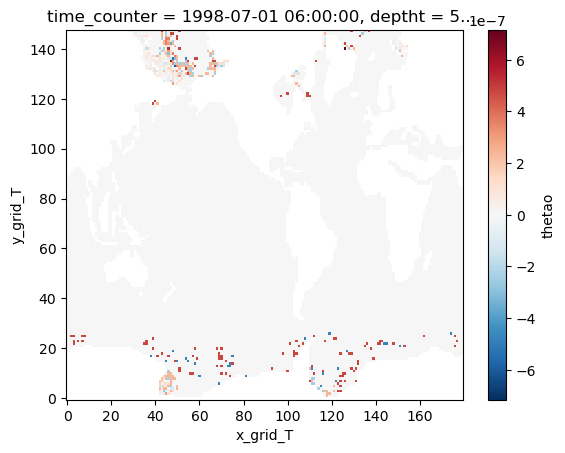

In [6]:
delta = xdata[var].isel(time_counter=-1,deptht=0)-fdata[var].isel(deptht=0)
delta.plot()

In [7]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), "restart.nc")
ndata = xr.open_mfdataset(filename, use_cftime=True)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), "FE00_*_restart.nc")
rdata = xr.open_mfdataset(filename, use_cftime=True)

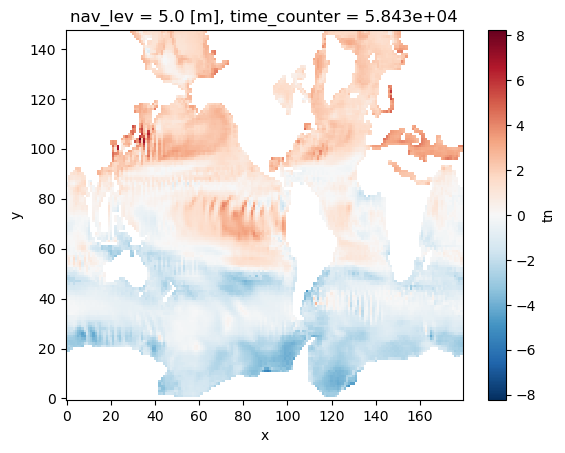

In [8]:
delta = ndata['tn'].isel(time_counter=0,nav_lev=0)-rdata['tn'].isel(time_counter=0,nav_lev=0)
delta.plot()

In [33]:
xdata = xdata.rename_dims({'x_grid_T': 'x', 'y_grid_T': 'y'})
xdata = xdata.rename({'nav_lat_grid_T': 'lat','nav_lon_grid_T': 'lon'})
xdata = xdata.rename({'time_counter': 'time'})
xdata = xdata.rename({'deptht': 'z'})

In [34]:
fdata = fdata.rename_dims({'x_grid_T': 'x', 'y_grid_T': 'y'})
fdata = fdata.rename({'nav_lat_grid_T': 'lat','nav_lon_grid_T': 'lon'})
fdata = fdata.rename({'deptht': 'z'})

In [41]:
fdata.attrs['name'] = xdata.attrs['name']

In [42]:
xpa = spacemean(xdata.isel(time=-1), var, '2D')
fpa = spacemean(fdata, var, '2D')

In [52]:
fpa['z'].values

array([4.9999380e+00, 1.5000288e+01, 2.5001759e+01, 3.5005413e+01,
       4.5013317e+01, 5.5029499e+01, 6.5061806e+01, 7.5125511e+01,
       8.5250366e+01, 9.5494286e+01, 1.0596992e+02, 1.1689624e+02,
       1.2869791e+02, 1.4219525e+02, 1.5896062e+02, 1.8196278e+02,
       2.1664792e+02, 2.7247672e+02, 3.6430304e+02, 5.1153476e+02,
       7.3220087e+02, 1.0332173e+03, 1.4056975e+03, 1.8308850e+03,
       2.2897678e+03, 2.7682424e+03, 3.2574788e+03, 3.7524421e+03,
       4.2504014e+03, 4.7499131e+03, 5.2502266e+03], dtype=float32)

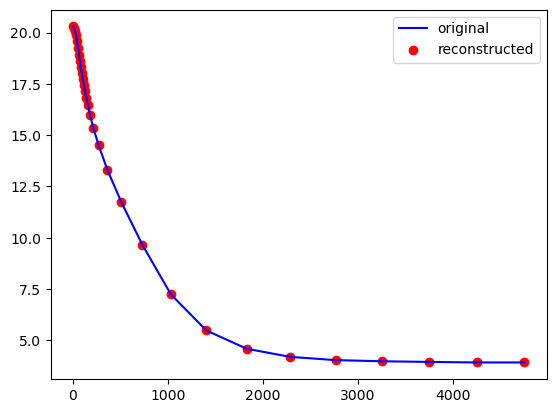

In [59]:
plt.plot(xpa['z'].values,xpa.values, color='b', label='original')
plt.scatter(fpa['z'].values,fpa.values, color='r', label='reconstructed')
plt.legend(loc="upper right")